# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s): 
Prof. Nitin J. Sanket (nsanket@wpi.edu), Lening Li (lli4@wpi.edu), Gejji, Vaishnavi Vivek (vgejji@wpi.edu)

Robotics Engineering Department,

Worcester Polytechnic Institute

Code adapted from CMSC733 at the University of Maryland, College Park.


## Phase 1




### Get the BSDS500 dataset

In [1]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!move BSDS500/ /content/data/

--2024-01-15 20:47:00--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812060 (793K) [application/octet-stream]
Saving to: 'BSDS500.tar.xz.1'

     0K .......... .......... .......... .......... ..........  6% 1.73M 0s
    50K .......... .......... .......... .......... .......... 12% 2.34M 0s
   100K .......... .......... .......... .......... .......... 18% 3.73M 0s
   150K .......... .......... .......... .......... .......... 25% 2.43M 0s
   200K .......... .......... .......... .......... .......... 31% 53.2M 0s
   250K .......... .......... .......... .......... .......... 37%  808K 0s
   300K .......... .......... .......... .......... .......... 44% 4.66M 0s
   350K ........

In [2]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!move TxtFiles/ /content/data/

--2024-01-13 10:47:15--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55376 (54K) [application/octet-stream]
Saving to: 'TxtFiles.tar.xz.1'

     0K .......... .......... .......... .......... .......... 92% 1.65M 0s
    50K ....                                                  100% 5.23M=0.03s

2024-01-13 10:47:15 (1.74 MB/s) - 'TxtFiles.tar.xz.1' saved [55376/55376]

x TxtFiles/
x TxtFiles/DirNamesTest.txt
x TxtFiles/DirNamesTrain.txt
x TxtFiles/LabelsTest.txt
x TxtFiles/LabelsTrain.txt
The system cannot find the file specified.


In [106]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import glob
from sklearn.cluster import KMeans


1. Generate Difference of Gaussian Filter Bank: (DoG)
2. Display all the filters in this filter bank and save image as DoG.png,
3. use command "cv2.imwrite(...)"

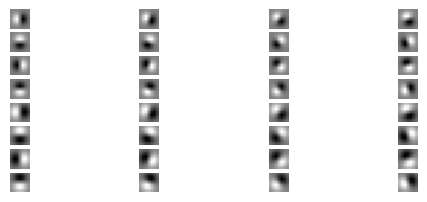

In [107]:
size = 7
num_orientations = 16
scale = np.power([1, 2], 0.5)

def convolve(image, kernel, width, height):
    output = np.zeros_like(image)
    image_temp = np.pad(image, ((1,1),(1,1)), 'constant') #depends on mask, for larger masks more padding
    for i in range(height):
        for j in range(width):
            output[i][j] = np.sum(image_temp[i:i+len(kernel), j:j+len(kernel)] * kernel)
    
    return output

sobel_x = [[-1, 0, 1],[-2, 0, 2], [-1, 0, 1]]
sobel_y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

x, y = np.meshgrid(np.linspace(-(size - 1)/2, (size - 1)/2, size), np.linspace(-(size - 1)/2, (size - 1)/2, size))
DoG_filter_bank = []

for s in scale:
    gaussian_x = np.exp(-0.5*np.square(x)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian_y = np.exp(-0.5*np.square(y)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian2d = gaussian_x * gaussian_y

    gx = convolve(gaussian2d, sobel_x, size, size)
    gy = convolve(gaussian2d, sobel_y, size, size)

    for o in range(num_orientations):
        theta = o * 2 * np.pi / num_orientations
        filter = gx * np.cos(theta) + gy * np.sin(theta)
        DoG_filter_bank.append(filter)

for i in range(len(DoG_filter_bank)):
    plt.subplot(16,4,i+1)
    plt.axis('off')
    plt.imshow(DoG_filter_bank[i], cmap='gray') 


1. Generate Leung-Malik Filter Bank: (LM)
2. Display all the filters in this filter bank and save image as LM.png,
3. use command "cv2.imwrite(...)"


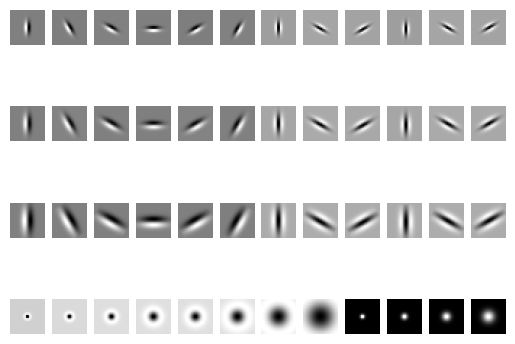

In [108]:
LM_filter_bank = []
LMS_filter_bank = []
LML_filter_bank = []
size = 24
num_orientations = 6
scale = [1, 2**0.5, 2, 8**0.5]
# scale = np.power([1, 2, 4, 8], 0.5)

#create generate gaussian function

x, y = np.meshgrid(np.linspace(-(size - 1)/2, (size - 1)/2, size), np.linspace(-(size - 1)/2, (size - 1)/2, size))
    
for s in scale[0:3]:
    # dx = [-1, 0, 1]
    # dx = [[0, 1, 0], [-1, 0, 1], [0, -1, 0]]
    # dy = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

    gaussian_x = np.exp(-0.5*np.square(x)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian_y = np.exp(-0.5*np.square(y)/np.square(3*s))/(np.sqrt(np.pi*2)*3*s)
    gaussian2d = gaussian_x * gaussian_y

    d_gaussian = -x/np.square(s) * gaussian2d 
    d2_gaussian = (np.square(x) - np.square(s))/np.power(s,4) * gaussian2d
    
    #first derivative filters
    for o in range(num_orientations):
        theta = o * 180 / num_orientations
        filter = imutils.rotate(d_gaussian, theta)
        LMS_filter_bank.append(filter)

    #second derivative filters
    for o in range(num_orientations):
        theta = o * 360 / num_orientations
        filter = imutils.rotate(d2_gaussian, theta)
        LMS_filter_bank.append(filter)

scale_new = scale
scale_new[5:8] = [3*i for i in scale]

for s in scale:

    gaussian_x = np.exp(-0.5*np.square(x)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian_y = np.exp(-0.5*np.square(y)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian2d = gaussian_x * gaussian_y
    log = (np.square(x) + np.square(y) - 2*np.square(s))/np.power(s,4) * gaussian2d
    
    LMS_filter_bank.append(log)

for s in scale[0:4]:
    gaussian_x = np.exp(-0.5*np.square(x)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian_y = np.exp(-0.5*np.square(y)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian2d = gaussian_x * gaussian_y
    LMS_filter_bank.append(gaussian2d)

for i in range(len(LMS_filter_bank)):
    plt.subplot(4,12,i+1)
    plt.axis('off')
    plt.imshow(LMS_filter_bank[i], cmap='gray') 

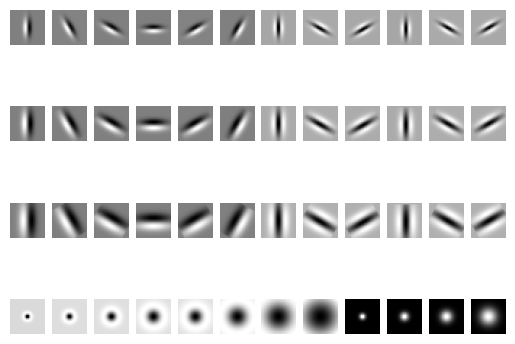

In [109]:

scale = [2**0.5, 2, 8**0.5, 4]

for s in scale[0:3]:
    # dx = [-1, 0, 1]
    # dx = [[0, 1, 0], [-1, 0, 1], [0, -1, 0]]
    # dy = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

    gaussian_x = np.exp(-0.5*np.square(x)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian_y = np.exp(-0.5*np.square(y)/np.square(3*s))/(np.sqrt(np.pi*2)*3*s)
    gaussian2d = gaussian_x * gaussian_y

    d_gaussian = -x/np.square(s) * gaussian2d 
    d2_gaussian = (np.square(x) - np.square(s))/np.power(s,4) * gaussian2d
    
    #first derivative filters
    for o in range(num_orientations):
        theta = o * 180 / num_orientations
        filter = imutils.rotate(d_gaussian, theta)
        LML_filter_bank.append(filter)

    #second derivative filters
    for o in range(num_orientations):
        theta = o * 360 / num_orientations
        filter = imutils.rotate(d2_gaussian, theta)
        LML_filter_bank.append(filter)

scale_new = scale
scale_new[5:8] = [3*i for i in scale]

for s in scale:

    gaussian_x = np.exp(-0.5*np.square(x)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian_y = np.exp(-0.5*np.square(y)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian2d = gaussian_x * gaussian_y
    log = (np.square(x) + np.square(y) - 2*np.square(s))/np.power(s,4) * gaussian2d
    
    LML_filter_bank.append(log)

for s in scale[0:4]:
    gaussian_x = np.exp(-0.5*np.square(x)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian_y = np.exp(-0.5*np.square(y)/np.square(s))/(np.sqrt(np.pi*2)*s)
    gaussian2d = gaussian_x * gaussian_y
    LML_filter_bank.append(gaussian2d)

for i in range(len(LML_filter_bank)):
    plt.subplot(4,12,i+1)
    plt.axis('off')
    plt.imshow(LML_filter_bank[i], cmap='gray') 

LM_filter_bank = LMS_filter_bank + LML_filter_bank

1. Generate Gabor Filter Bank: (Gabor)
2. Display all the filters in this filter bank and save image as Gabor.png,
3. use command "cv2.imwrite(...)"


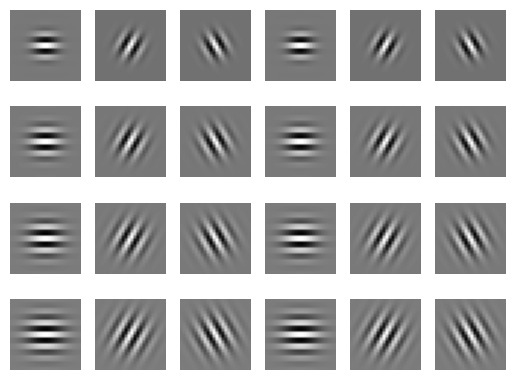

In [110]:
Gabor_filter_bank = []
size = 24
scale = np.power([8, 12, 16, 20], 0.5)
num_orientations = 6

x, y = np.meshgrid(np.linspace(-(size - 1)/2, (size - 1)/2, size), np.linspace(-(size - 1)/2, (size - 1)/2, size))
lambda_ = 4
for s in scale:
    
    for o in range(num_orientations):
        theta = o * 360 / num_orientations
        rad = theta * np.pi/180
        x_p = x * np.sin(rad) + y * np.cos(rad)
        y_p = x * np.cos(rad) - y * np.sin(rad)
        gaussian_x = np.exp(-0.5*np.square(x_p)/np.square(s))/(np.sqrt(np.pi*2)*s)
        gaussian_y = np.exp(-0.5*np.square(y_p)/np.square(s))/(np.sqrt(np.pi*2)*s)
        gaussian2d = gaussian_x * gaussian_y
        sinusoidal_mod = np.cos(2 * np.pi * x_p / lambda_)
        filter = gaussian2d * sinusoidal_mod
        Gabor_filter_bank.append(filter)
    
for i in range(len(Gabor_filter_bank)):
    plt.subplot(4,6,i+1)
    plt.axis('off')
    plt.imshow(Gabor_filter_bank[i], cmap='gray') 


1. Generate Half-disk masks
2. Display all the Half-disk masks and save image as HDMasks.png,
3. use command "cv2.imwrite(...)"

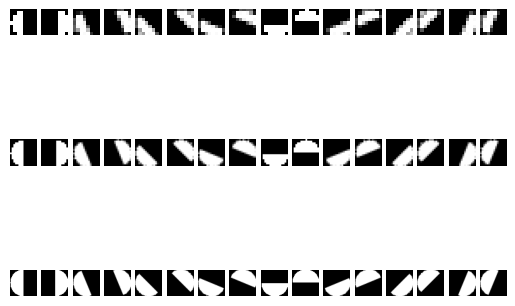

In [111]:
half_disk_masks = []
scale = np.multiply([1 , 2 ,5],4)
num_orientations = 8

def populate_circle(radius):
    filter = np.zeros([2 * radius, 2 * radius]) 
    for i in range(2 * radius): 
        for j in range(radius): #populating the area within the half circle with 1, not the full
            if np.power(i - radius, 2) + np.power(j - radius, 2) <= np.power(radius,2):
                filter[i][j] = 1
    return filter

for s in scale:
    half_disk = populate_circle(s)
    for o in range(num_orientations):
        half_theta =  o * 180 / num_orientations
        half_disk_masks.append(imutils.rotate(half_disk, half_theta))
        half_disk_masks.append(imutils.rotate(half_disk, half_theta + 180))

for i in range(len(half_disk_masks)):
    plt.subplot(3,16,i+1)
    plt.axis('off')
    plt.imshow(half_disk_masks[i], cmap='gray') 
    plt.imsave("Filters/HalfDisk_"+ str(i+1)+".jpg", half_disk_masks[i])

1. Generate Texton Map
2. Filter image using oriented gaussian filter bank


In [112]:

filter_bank = DoG_filter_bank + LM_filter_bank + Gabor_filter_bank

def generate_filter_response(image, filters):
    filter_response_set = []
    i = 0
    for f in filters:
        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # filter_response = convolve(grayscale ,f, image.shape[0], image.shape[1])
        filter_response = cv2.filter2D(grayscale, -1, f)
        filter_response_set.append(filter_response)
        i = i + 1

    return filter_response_set

image_set = []
filepath = glob.glob("BSDS500/Images/*.jpg")

for i in filepath: #populating the image set for filtering
    image = cv2.imread(i)
    image_set.append(image)


1. Generate texture ID's using K-means clustering
2. Display texton map and save image as TextonMap_ImageName.png,
3. use command "cv2.imwrite('...)"


In [113]:
count = 1
texton_map = []

for i in image_set:
    
    filter_response_set = generate_filter_response(i, filter_bank)    
    filter_response_array = np.array(filter_response_set)
    
    set_size = filter_response_array.shape
    mod_image = filter_response_array.reshape(set_size[0], set_size[1]*set_size[2])
    mod_image = mod_image.transpose()

    kms = KMeans(n_clusters = 64, n_init = 2)
    kmcluster = kms.fit(mod_image)
    labels = kmcluster.predict(mod_image)
    tm = labels.reshape([set_size[1], set_size[2]])
    
    plt.imsave("Results/TextonMap_"+ str(count)+".png", tm)
    texton_map.append(tm)
    count += 1

1. Generate Texton Gradient (Tg)
2. Perform Chi-square calculation on Texton Map
3. Display Tg and save image as Tg_ImageName.png,
4. use command "cv2.imwrite(...)"


In [114]:
def calculate_chi_distance(texton_image, k):
    
    chi_distance = []
    chi = np.zeros_like(texton_image)
    
    for i in range(0, len(half_disk_masks), 2):
        
        left = half_disk_masks[i]
        right = half_disk_masks[i+1]
        tmp = np.zeros_like(texton_image)
        
        for j in range(k):
            
            tmp = texton_image == j #wherever texton_id matches
            tmp = np.float32(tmp)

            g_j = cv2.filter2D(tmp, -1, left)
            h_j = cv2.filter2D(tmp, -1, right)

            chi = chi + 0.5 * ((g_j - h_j) ** 2)/(g_j + h_j + 0.01)
        
        chi_distance.append(chi)
    
    return chi_distance

T_g = []
count = 1
for i in texton_map:

    chi = calculate_chi_distance(i, 64)
    chi_avg = np.mean(chi, axis = 0)
    plt.imsave("Results/Tg_" + str(count) + ".png", chi_avg)
    T_g.append(chi_avg)
    count += 1


1. Generate Brightness Map
2. Perform brightness binning


In [115]:
count = 1
brightness_map = []
for i in image_set:
    grayscale = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    grayscale_array = np.array(grayscale)
    set_size = grayscale_array.shape

    mod_image = grayscale_array.reshape(set_size[0]*set_size[1], 1)
    
    kms = KMeans(n_clusters = 16, n_init = 2)
    kmcluster = kms.fit(mod_image)
    labels = kmcluster.predict(mod_image)
    bm = labels.reshape([set_size[0], set_size[1]])
    
    plt.imsave("Results/BrightMap_"+ str(count)+".png", bm)
    brightness_map.append(bm)
    count += 1

1. Generate Brightness Gradient (Bg)
2. Perform Chi-square calculation on Brightness Map
3. Display Bg and save image as Bg_ImageName.png,
4. use command "cv2.imwrite(...)"



In [116]:
B_g = []
count = 1
for i in brightness_map:

    chi = calculate_chi_distance(i, 16)
    chi_avg = np.mean(chi, axis = 0)
    plt.imsave("Results/Bg_" + str(count) + ".png", chi_avg)
    B_g.append(chi_avg)
    count += 1

1. Generate Color Map
2. Perform color binning or clustering


In [117]:
count = 1
color_map = []
for i in image_set:

    color_array = np.array(i)
    set_size = color_array.shape
    mod_image = color_array.reshape(set_size[0]*set_size[1], set_size[2])
    
    kms = KMeans(n_clusters = 16, n_init = 2)
    kmcluster = kms.fit(mod_image)
    labels = kmcluster.predict(mod_image)
    
    cm = labels.reshape([set_size[0], set_size[1]])
    plt.imsave("Results/ColorMap_"+ str(count)+".png", cm)
    color_map.append(cm)
    count += 1




1. Generate Color Gradient (Cg)
2. Perform Chi-square calculation on Color Map
3. Display Cg and save image as Cg_ImageName.png,
4. use command "cv2.imwrite(...)"



In [118]:
C_g = []
count = 1
for i in color_map:

    chi = calculate_chi_distance(i, 16)
    chi_avg = np.mean(chi, axis = 0)
    plt.imsave("Results/Cg_" + str(count) + ".png", chi_avg)
    C_g.append(chi_avg)
    count += 1


1. Read Sobel Baseline
2. use command "cv2.imread(...)"


In [119]:
sobel_baseline =[]
filepath = glob.glob("BSDS500/SobelBaseline/*.png")

for i in filepath:

    image = cv2.imread(i)
    sobel_baseline.append(image)




1. Read Canny Baseline
2. use command "cv2.imread(...)"



In [120]:
canny_baseline =[]
filepath = glob.glob("BSDS500/CannyBaseline/*.png")

for i in filepath:

    image = cv2.imread(i)
    canny_baseline.append(image)



1. Combine responses to get pb-lite output
2. Display PbLite and save image as PbLite_ImageName.png
3. use command "cv2.imwrite(...)"



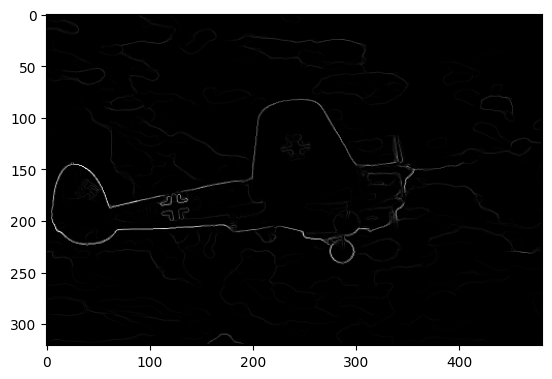

In [121]:
count = 0
w1 = 0.5
w2 = 0.5
pb_baseline = []
for i in image_set:

    pb = (T_g[count] + B_g[count]+ C_g[count])/3
    canny_img = cv2.cvtColor(canny_baseline[count], cv2.COLOR_BGR2GRAY)
    sobel_img = cv2.cvtColor(sobel_baseline[count], cv2.COLOR_BGR2GRAY)

    pb = pb * (w1 * canny_img + w2 * sobel_img)
    pb_baseline.append(pb)
    
    plt.imsave("Results/PbLite_"+ str(count+1)+".png", pb, cmap='gray')
    plt.imshow(pb_baseline[0], cmap='gray')
    count += 1
    

## Phase 2

### Neural Network Construction

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    loss = nn.CrossEntropyLoss()(out, labels)
    return loss

class ImageClassificationBase(nn.Module):
    def training_step(self, batch, Writer):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        Writer.add_graph(self, images)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, result['loss'], result['acc']))



class CIFAR10Model(ImageClassificationBase):
  def __init__(self, InputSize, OutputSize):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################

      super().__init__()
      self.cn1 = nn.Conv2d(3, 10, 3,padding=1, stride=1)
      self.mp = nn.MaxPool2d(2, 2)
      self.cn2 = nn.Conv2d(10, 20, 3,padding=1, stride=1)
      self.fc1 = nn.Linear(1280, 128)
      self.fc2 = nn.Linear(128, 64)
      self.fc3 = nn.Linear(64, 10)

  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################

      out = self.mp(F.relu(self.cn1(xb)))
      out = self.mp(F.relu(self.cn2(out)))
      out = out.view(-1, 1280) #reshaping
      out = F.relu(self.fc1(out))
      out = F.relu(self.fc2(out))
      out = F.relu(self.fc3(out))

      return out

class CIFAR10Model2(ImageClassificationBase):
  def __init__(self, InputSize, OutputSize):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################

      super().__init__()
      self.cn1 = nn.Conv2d(3, 10, 3, padding=1)
      self.cn1_bn = nn.BatchNorm2d(10)
      self.mp = nn.MaxPool2d(2, 2)
      self.cn2 = nn.Conv2d(10, 20, 3, padding=1)
      self.cn2_bn = nn.BatchNorm2d(20)
      self.fc1 = nn.Linear(1280, 128)
      self.fc2 = nn.Linear(128, 64)
      self.fc2_bn = nn.BatchNorm1d(64)
      self.fc3 = nn.Linear(64, 10)

  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################

      out = self.cn1_bn(self.cn1(xb))
      out = self.mp(F.relu(out))
      out = self.mp(F.relu(self.cn2(out)))
      out = out.view(-1, 1280) #reshaping

      out = F.relu(self.fc1(out))
      out = F.relu(self.fc2_bn(self.fc2(out)))
      out = F.relu(self.fc3(out))

      return out

class ResNet(ImageClassificationBase):
  def __init__(self, InputSize, OutputSize):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################
      super().__init__()
      self.idty = nn.Identity()
      self.cn1 = nn.Conv2d(3, 16, 3, padding=1)
      self.cn2 = nn.Conv2d(16, 16, 3, padding=1)
      self.cn3 = nn.Conv2d(16, 16, 3, padding=1)
      self.fc1 = nn.Linear(16384, 1024)
      self.fc2 = nn.Linear(1024, 84)
      self.fc3 = nn.Linear(84, 10)

  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################

      out = F.relu(self.cn1(xb))
      skip  = out
      out = F.relu(self.cn3(self.cn2(out)))
      out = out + self.idty(skip)
      out = out.view(-1, 32*32*16)
      out = F.sigmoid(self.fc1(out))
      out = F.sigmoid(self.fc2(out))
      out = F.softmax(self.fc3(out))
      return out

class ResNeXT(ImageClassificationBase):
  def __init__(self, InputSize, OutputSize):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################
      super().__init__()
      self.idty = nn.Identity()
      self.cn1 = nn.Conv2d(3, 10, 3, padding=1)
      self.cn2 = nn.Conv2d(10, 5, 3, padding=1)
      self.cn3 = nn.Conv2d(5, 5, 3, padding=1)
      self.cn4 = nn.Conv2d(5, 10, 3, padding=1)
      self.cn5 = nn.Conv2d(10, 10, 3, padding=1)
      self.cn6 = nn.Conv2d(10, 20, 3, padding=1)
      self.cn7 = nn.Conv2d(20, 10, 3, padding=1)
      self.cn8 = nn.Conv2d(10, 20, 3, padding=1)
      self.cn9 = nn.Conv2d(20, 40, 3, padding=1)
      self.cn10 = nn.Conv2d(40, 40, 3, padding=1)
      self.cn11 = nn.Conv2d(40, 20, 3, padding=1)
      self.cn12 = nn.Conv2d(20, 10, 3, padding=1)
      self.cn13 = nn.Conv2d(10, 5, 3, padding=1)
      self.cn14 = nn.Conv2d(5, 20, 3, padding=1)
      self.fc1 = nn.Linear(20480, 1024)
      self.fc2 = nn.Linear(1024, 84)
      self.fc3 = nn.Linear(84, 10)

  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################
      out = F.relu(self.cn1(xb))
      x  = out
      out1 = F.relu(self.cn2(out))
      out1 = F.relu(self.cn3(out1))
      x1 = F.relu(self.cn4(out1))
      out2 = F.relu(self.cn5(out))
      out2 = F.relu(self.cn6(out2))
      x2 = F.relu(self.cn7(out2))
      out = self.idty(x) + x1 + x2

      x  = F.relu(self.cn8(out))
      out1 = F.relu(self.cn9(x))
      out1 = F.relu(self.cn10(out1))
      x1 = F.relu(self.cn11(out1))
      out2 = F.relu(self.cn12(x))
      out2 = F.relu(self.cn13(out2))
      x2 = F.relu(self.cn14(out2))
      out = self.idty(x) + x1 + x2

      out = out.view(-1, 20480)
      out = F.sigmoid(self.fc1(out))
      out = F.sigmoid(self.fc2(out))
      out = F.softmax(self.fc3(out))
      return out

class DenseNet(ImageClassificationBase):
  def __init__(self, InputSize, OutputSize):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################
      super().__init__()
      self.idty = nn.Identity()
      self.cn1 = nn.Conv2d(3, 10, 3, padding=1)
      self.cn2 = nn.Conv2d(10, 10, 3, padding=1)
      self.cn3 = nn.Conv2d(10, 10, 3, padding=1)
      self.cn4 = nn.Conv2d(10, 20, 3, padding=1)
      self.cn5 = nn.Conv2d(20, 20, 3, padding=1)
      self.cn6 = nn.Conv2d(20, 20, 3, padding=1)
      self.fc1 = nn.Linear(32*32*20, 1024)
      self.fc2 = nn.Linear(1024, 84)
      self.fc3 = nn.Linear(84, 10)

  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################
      out = F.relu(self.cn1(xb))
      x = out
      x1 = F.relu(self.cn2(out))
      out = self.idty(x) + x1
      x2 = F.relu(self.cn3(out))
      out = self.idty(x) + x1 + x2
      x = F.relu(self.cn4(out))
      x1 = F.relu(self.cn5(x))
      out = self.idty(x) + x1
      x2 = self.cn6(out)
      out = self.idty(x) + x1 + x2
      out = out + self.idty(x)
      out = out.view(-1, 32*32*20)
      out = F.sigmoid(self.fc1(out))
      out = F.sigmoid(self.fc2(out))
      out = F.softmax(self.fc3(out))
      return out


In [12]:
import time
import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime

def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)

### Train your neural network

In [13]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import argparse
import shutil
import string
from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm

def SetupAll(CheckPointPath):
    """
    Inputs:
    CheckPointPath - Path to save checkpoints/model
    Outputs:
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    ImageSize - Size of the image
    NumTrainSamples - length(Train)
    TrainLabels - Labels corresponding to Train
    NumClasses - Number of classes
    """
    # Read and Setup Labels
    LabelsPathTrain = '/content/data/TxtFiles/LabelsTrain.txt'
    # LabelsPathTrain = 'TxtFiles/LabelsTrain.txt'
    TrainLabels = ReadLabels(LabelsPathTrain)

    # If CheckPointPath doesn't exist make the path
    if(not (os.path.isdir(CheckPointPath))):
       os.makedirs(CheckPointPath)

    # Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    SaveCheckPoint = 100

    # Image Input Shape
    ImageSize = [32, 32, 3]
    NumTrainSamples = len(TrainSet)

    # Number of classes
    NumClasses = 10

    return SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses


def ReadLabels(LabelsPathTrain):
    if(not (os.path.isfile(LabelsPathTrain))):
        print('ERROR: Train Labels do not exist in '+LabelsPathTrain)
        sys.exit()
    else:
        TrainLabels = open(LabelsPathTrain, 'r')
        TrainLabels = TrainLabels.read()
        TrainLabels = map(float, TrainLabels.split())

    return TrainLabels


def ReadDirNames(ReadPath):
    """
    Inputs:
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames is the data loaded from /content/data/TxtFiles/DirNames.txt which has full path to all image files without extension
    """
    # Read text files
    DirNames = open(ReadPath, 'r')
    DirNames = DirNames.read()
    DirNames = DirNames.split()
    return DirNames


def GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize):
    """
    Inputs:
    TrainSet - Variable with Subfolder paths to train files
    NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
    TrainLabels - Labels corresponding to Train
    NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
    ImageSize is the Size of the Image
    MiniBatchSize is the size of the MiniBatch

    Outputs:
    I1Batch - Batch of images
    LabelBatch - Batch of one-hot encoded labels
    """
    I1Batch = []
    LabelBatch = []

    ImageNum = 0
    while ImageNum < MiniBatchSize:
        # Generate random image
        RandIdx = random.randint(0, len(TrainSet)-1)
        ImageNum += 1

    	  ##########################################################
    	  # Add any standardization or data augmentation here!
    	  ##########################################################
        # transforms = v2.Compose([
        #             # v2.RandomResizedCrop(size=(40, 40), antialias=True),
        #             # v2.RandomHorizontalFlip(p=0.5),
        #             v2.ToDtype(torch.float32, scale=True),
        #             v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #             ])
        I1, Label = TrainSet[RandIdx]
        # I1 = transforms(I1)
        # Label = convertToOneHot(TrainLabels[RandIdx], 10)

        # Append All Images and Mask
        I1Batch.append(I1)
        LabelBatch.append(torch.tensor(Label))

    return torch.stack(I1Batch), torch.stack(LabelBatch)


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
    """
    Prints all stats with all arguments
    """
    print('Number of Epochs Training will run for ' + str(NumEpochs))
    print('Factor of reduction in training data is ' + str(DivTrain))
    print('Mini Batch Size ' + str(MiniBatchSize))
    print('Number of Training Images ' + str(NumTrainSamples))
    if LatestFile is not None:
        print('Loading latest checkpoint with the name ' + LatestFile)

def TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                   NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                   DivTrain, LatestFile, TrainSet, LogsPath):
    """
    Inputs:
    TrainLabels - Labels corresponding to Train/Test
    NumTrainSamples - length(Train)
    ImageSize - Size of the image
    NumEpochs - Number of passes through the Train data
    MiniBatchSize is the size of the MiniBatch
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    CheckPointPath - Path to save checkpoints/model
    DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
    LatestFile - Latest checkpointfile to continue training
    TrainSet - The training dataset
    LogsPath - Path to save Tensorboard Logs
    Outputs:
    Saves Trained network in CheckPointPath and Logs to LogsPath
    """
    # Initialize the model
    model = CIFAR10Model(InputSize= 3072 ,OutputSize=10)
    # model = CIFAR10Model2(InputSize= 3072 ,OutputSize=10)
    # model = ResNet(InputSize= 3072 ,OutputSize=10)
    # model = ResNeXT(InputSize= 3072 ,OutputSize=10)
    # model = DenseNet(InputSize= 3072 ,OutputSize=10)
    model.eval()

    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
    Optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    # Tensorboard
    # Create a summary to monitor loss tensor
    Writer = SummaryWriter(LogsPath)

    if LatestFile is not None:
        CheckPoint = torch.load(CheckPointPath + LatestFile + '.ckpt')
        # Extract only numbers from the name
        StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
        model.load_state_dict(CheckPoint['model_state_dict'])
        print('Loaded latest checkpoint with the name ' + LatestFile + '....')
    else:
        StartEpoch = 0
        print('New model initialized....')

    for Epochs in tqdm(range(StartEpoch, NumEpochs)):
        NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
        for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
            Batch = GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize)

            # Predict output with forward pass
            LossThisBatch = model.training_step(Batch, Writer)

            Optimizer.zero_grad()
            LossThisBatch.backward()
            Optimizer.step()

            # Save checkpoint every some SaveCheckPoint's iterations
            if PerEpochCounter % SaveCheckPoint == 0:
                # Save the Model learnt in this epoch
                SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'

                torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
                print('\n' + SaveName + ' Model Saved...')

            result = model.validation_step(Batch)
            model.epoch_end(Epochs*NumIterationsPerEpoch + PerEpochCounter, result)
            # Tensorboard
            Writer.add_scalar('LossEveryIter', result["loss"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            Writer.add_scalar('Accuracy', result["acc"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            # If you don't flush the tensorboard doesn't update until a lot of iterations!
            Writer.flush()

        # Save model every epoch
        SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
        torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
        print('\n' + SaveName + ' Model Saved...')



# Default Hyperparameters
# NumEpochs = 10 # for simple model
NumEpochs = 25
TrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=ToTensor())
DivTrain = 1.0
# MiniBatchSize = 256 # for simple model
MiniBatchSize = 512
LoadCheckPoint = 0
CheckPointPath = "/content/Checkpoints/"
LogsPath = "/content/Logs"

# Setup all needed parameters including file reading
SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses = SetupAll(CheckPointPath)

# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, TrainSet, LogsPath)

Files already downloaded and verified
Number of Epochs Training will run for 25
Factor of reduction in training data is 1.0
Mini Batch Size 512
Number of Training Images 50000
New model initialized....


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]


/content/Checkpoints/0a0model.ckpt Model Saved...
Epoch [0], loss: 2.3029, acc: 0.0996
Epoch [1], loss: 2.3002, acc: 0.1328
Epoch [2], loss: 2.2969, acc: 0.1387
Epoch [3], loss: 2.3003, acc: 0.1113
Epoch [4], loss: 2.3037, acc: 0.0918
Epoch [5], loss: 2.3042, acc: 0.0781
Epoch [6], loss: 2.3017, acc: 0.0898
Epoch [7], loss: 2.2988, acc: 0.1621
Epoch [8], loss: 2.2989, acc: 0.1133
Epoch [9], loss: 2.2948, acc: 0.1133
Epoch [10], loss: 2.2967, acc: 0.1055
Epoch [11], loss: 2.2983, acc: 0.0918
Epoch [12], loss: 2.2960, acc: 0.1367
Epoch [13], loss: 2.2948, acc: 0.1660
Epoch [14], loss: 2.2898, acc: 0.1914
Epoch [15], loss: 2.2886, acc: 0.1660
Epoch [16], loss: 2.2849, acc: 0.1523
Epoch [17], loss: 2.2780, acc: 0.1523
Epoch [18], loss: 2.2806, acc: 0.1426


KeyboardInterrupt: 

### Test your neural network

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\niran\AppData\Local\Temp\ipykernel_20172\1585483989.py:353: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.fc3(out))


Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of parameters in this model are 34 


  0%|          | 0/10000 [00:00<?, ?it/s]

[813  51   4   5   0   2   4   9  60  52] (0)
[174 634   2   1   0   2   1  10  45 131] (1)
[479  59 109  46   7  50   3  73  85  89] (2)
[261 109  56 152   7  99   8  87  88 133] (3)
[468  63  66  48  15  35   5 123  86  91] (4)
[169  78  60 114   3 267   8 138  70  93] (5)
[301 168  57  33  12  23  35  46 119 206] (6)
[234  36  30  21   8  32   0 503  35 101] (7)
[320 119   2   4   1   1   0   4 422 127] (8)
[191 189   2   2   0   4   0  16  35 561] (9)
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
Accuracy: 35.11 %


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (2).

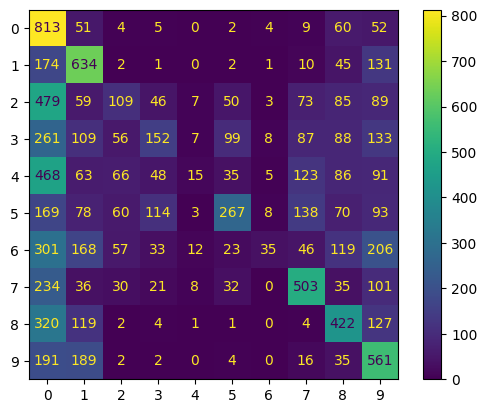

In [105]:
import cv2
import os
import sys
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor, functional
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch

def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """
    # Image Input Shape
    ImageSize = [32, 32, 3]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img

def ReadImages(Img):
    """
    Outputs:
    I1Combined - I1 image after any standardization and/or cropping/resizing to ImageSize
    I1 - Original I1 image for visualization purposes only
    """
    I1 = Img

    if(I1 is None):
        # OpenCV returns empty list if image is not read!
        print('ERROR: Image I1 cannot be read')
        sys.exit()

    I1S = StandardizeInputs(np.float32(I1))

    I1Combined = np.expand_dims(I1S, axis=0)

    return I1Combined, I1


def TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred):
    """
    Inputs:
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to /content/data/TxtFiles/PredOut.txt
    """
    # Predict output with forward pass, MiniBatchSize for Test is 1
    model = CIFAR10Model(InputSize= 3072 ,OutputSize=10)
    # model = CIFAR10Model2(InputSize =  3072 ,OutputSize=10)
    # model = ResNet(InputSize= 3072 ,OutputSize=10)
    # model = ResNeXT(InputSize= 3072 ,OutputSize=10)
    # model = DenseNet(InputSize= 3072 ,OutputSize=10)
    model.eval()

    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    print('Number of parameters in this model are %d ' % len(model.state_dict().items()))

    OutSaveT = open(LabelsPathPred, 'w')

    for count in tqdm(range(len(TestSet))):
        Img, Label = TestSet[count]
        Img, ImgOrg = ReadImages(Img)
        Img = np.reshape(Img,(32,32,3))
        Img = functional.to_tensor(Img)
        # PredT = model(Img)
        PredT = model(Img.unsqueeze(0))
        # PredT = torch.argmax(model(Img)).item()
        PredT = torch.argmax(model(Img.unsqueeze(0))).item()
        OutSaveT.write(str(PredT)+'\n')
    OutSaveT.close()

def Accuracy(Pred, GT):
    """
    Inputs:
    Pred are the predicted labels
    GT are the ground truth labels
    Outputs:
    Accuracy in percentage
    """
    return (np.sum(np.array(Pred)==np.array(GT))*100.0/len(Pred))

def ReadLabels(LabelsPathTest, LabelsPathPred):
    if(not (os.path.isfile(LabelsPathTest))):
        print('ERROR: Test Labels do not exist in '+LabelsPathTest)
        sys.exit()
    else:
        LabelTest = open(LabelsPathTest, 'r')
        LabelTest = LabelTest.read()
        LabelTest = map(float, LabelTest.split())

    if(not (os.path.isfile(LabelsPathPred))):
        print('ERROR: Pred Labels do not exist in '+LabelsPathPred)
        sys.exit()
    else:
        LabelPred = open(LabelsPathPred, 'r')
        LabelPred = LabelPred.read()
        LabelPred = map(float, LabelPred.split())

    return LabelTest, LabelPred

def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.
    LabelsTrue, LabelsPred = list(LabelsTrue), list(LabelsPred)
    cm = confusion_matrix(y_true=LabelsTrue,  # True class for test-set.
                          y_pred=LabelsPred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        print(str(cm[i, :]) + ' ({0})'.format(i))

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(10)]
    print("".join(class_numbers))

    print('Accuracy: '+ str(Accuracy(LabelsPred, LabelsTrue)), '%')

    return cm

for i in range(NumEpochs):
    # ModelPath = "/content/Checkpoints/0a100model.ckpt"
    ModelPath = "/content/Checkpoints/"+ str(i) +"a0model.ckpt"
    # LabelsPath = "TxtFiles/LabelsTest.txt"
    LabelsPath = "/content/data/TxtFiles/LabelsTest.txt"
    TestSet = CIFAR10(root='data/', train=False)


    # Setup all needed parameters including file reading
    ImageSize = SetupAll()

    # Define PlaceHolder variables for Input and Predicted output
    # LabelsPathPred = 'TxtFiles/PredOut.txt' # Path to save predicted labels
    LabelsPathPred = '/content/data/TxtFiles/PredOut.txt' # Path to save predicted labels

    TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred)

 # Plot Confusion Matrix
LabelsTrue, LabelsPred = ReadLabels(LabelsPath, LabelsPathPred)
cm = ConfusionMatrix(LabelsTrue, LabelsPred)
confusion_matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [True, True])
# confusion_matrix.plot()
# plt.show()

#printing model parameters
# def model_summary(model):
#   print("model_summary")
#   print()
#   print("Layer_name"+"\t"*7+"Number of Parameters")
#   print("="*100)
#   model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
#   layer_name = [child for child in model.children()]
#   j = 0
#   total_params = 0
#   print("\t"*10)
#   for i in layer_name:
#     print()
#     param = 0
#     try:
#       bias = (i.bias is not None)
#     except:
#       bias = False
#     if not bias:
#       param =model_parameters[j].numel()+model_parameters[j+1].numel()
#       j = j+2
#     else:
#       param =model_parameters[j].numel()
#       j = j+1
#     print(str(i)+"\t"*3+str(param))
#     total_params+=param
#   print("="*100)
#   print(f"Total Params:{total_params}")

# model = ResNeXT(InputSize= 3072 ,OutputSize=10)
# model_summary(model)